In [3]:
import simu_process.simulation as sim
from tools.generate_config import gen_config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures

In [8]:
def simulate_get_output(config_list):
    """
    run simulations and generate config files with different alpha values
    @param config_list: list of paths of config files
    @return: a list of all output files
    """
    output_files = []
    for config in config_list:
        # print(f'Run the simulations with config file: {config}')
        simu = sim.Simulation(config)
        simu.run_and_save()
        output = simu.output_file
        output_files.append(output)
    return output_files

def simulate_and_save(config):
    """
    Run simulation and save data for a given config file.
    @param config: path to the config file
    @return: path to the output file
    """
    simulation = sim.Simulation(config)
    simulation.run_and_save()

    return simulation.output_file


def concat_results(output_files):
    """
    get results data from output files for further analysis
    @param output_files: a list out output files
    @return: user_all and cc_all, general results of the files
    """
    u_list = []
    cc_list = []
    for i in output_files:
        # find alpha value
        alpha = i[i.find('alpha')+5: i.find('.pkl')]
        with open(i, 'rb') as file:
            loaded_data = pickle.load(file)
            user_df = loaded_data[0]
            # print(len(user_df))
            cc_df = loaded_data[1]
            user_df['alpha'] = float(alpha)
            cc_df['alpha'] = float(alpha)
            u_list.append(user_df)
            cc_list.append(cc_df)
    user_all = pd.concat(u_list).reset_index(drop=True)
    # print(user_all.columns)
    cc_all = pd.concat(cc_list)
    return user_all, cc_all

In [4]:
def user_searching_proportion(user_all):
    """
    Get the proportion of users stop searching at each step
    @param user_all: dataframe of user results after absorbed
    @return: dataframe with alpha, step, and proportion of users finish searching
    """
    all_counts = user_all.groupby('alpha')['id'].count()
    steps_counts = user_all.groupby(['alpha', 'steps'])['id'].count()
    ratios = steps_counts.div(all_counts, level='alpha').reset_index()
    ratios['proportion'] = ratios.groupby('alpha')['id'].cumsum()
    return ratios

def simu_stop_proportion(user_all, step_list):
    """
    get proportion of simulations stop at each step
    @param step_list: [1, 10, 20, 50, 200, 900] the threshold of steps
    @param user_all: dataframe of user results
    @return: dataframe with alpha, step, and proportion of iterations finished at the step
    """

    max_steps = user_all.groupby(['alpha', 'iteration'])['steps'].max().reset_index()

    result = []
    for step_threshold in step_list:
        step_counts = max_steps[max_steps['steps'] <= step_threshold].groupby('alpha')['iteration'].count()
        total_iterations = max_steps.groupby('alpha')['iteration'].count()
        proportions = step_counts / total_iterations
        #
        prop_df = pd.DataFrame(proportions).reset_index()
        prop_df['threshold'] = step_threshold
        result.append(prop_df)

    proportion_df = pd.concat(result)
    # proportion_df.columns = step_list

    # all_counts = max_steps.groupby('alpha')['iteration'].count()
    # steps_counts = max_steps.groupby(['alpha', 'steps'])['iteration'].count()
    # ratios = steps_counts.div(all_counts, level='alpha').reset_index()
    return proportion_df #.reset_index()

In [5]:
def cc_fair(cc_all):
    """
    Get the proportion of IF for each quality
    @param cc_all:
    @return: DataFrame of values of alphas, ids, proportion of IF
    """
    cc_all['rank'] = cc_all.groupby(['iteration', 'alpha'])['view'].rank(ascending=False)
    cc_all['IF'] = cc_all['rank'] <= cc_all['id']
    fair_ratio = cc_all.groupby(['alpha', 'id'])['IF'].mean().reset_index()
    return fair_ratio


## Preprocess
In this part, we first run the simulations and pre-process the output files of the simulations

In [5]:
# If already run the simulation, skip this cell
base_file = 'config.yaml'
value = 'alpha'
value_list = [-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
# value_list = [-1000, -2.5, -1, 0, 1, 2.5, 1000]
# get the file names of the config files
config_list = gen_config(base_file, value, value_list)



In [6]:
# run simulation and get output paths
output_files = simulate_get_output(config_list)

Iterations with alpha = 0:   0%|          | 0/100 [00:24<?, ?it/s]


KeyboardInterrupt: 

In [6]:
import os
directory_path = 'D:\Fairness-for-SMI\_output'  # 将这里替换为你的目录路径
file_names = os.listdir(directory_path)
output_files = [os.path.join(directory_path, file_name) for file_name in file_names]


In [9]:
user_all, cc_all = concat_results(output_files)

In [19]:
# How many users get the best creator within 1200 steps
grouped = user_all.groupby('alpha')['steps'].agg(['count', 'size'])

grouped['percentage'] = grouped['count'] / grouped['size']

result = grouped.reset_index()
result

,alpha,count,size,percentage
0,-1000.00,2483,100000,0.02483
1,-50.00,1527,100000,0.01527
2,-10.00,2190,100000,0.02190
3,-5.00,2945,100000,0.02945
4,-2.50,2318,100000,0.02318
5,-1.00,7707,100000,0.07707
6,-0.75,15160,100000,0.15160
7,-0.50,32366,100000,0.32366
8,-0.25,71291,100000,0.71291
9,0.00,98101,100000,0.98101


In [14]:
user_all[user_all['steps'] != 'NaN']

,id,steps,iteration,alpha
0,0,NaN,0,-1000.00
1,1,NaN,0,-1000.00
2,2,NaN,0,-1000.00
3,3,NaN,0,-1000.00
4,4,NaN,0,-1000.00
...,...,...,...,...
1899995,995,NaN,99,-0.25
1899996,996,1201.0,99,-0.25
1899997,997,NaN,99,-0.25
1899998,998,1201.0,99,-0.25


## Analysis
The individual Fairness of the CCs.

In [29]:
# define the plot function
def plot(df, a, b, c):

    custom_palette = sns.diverging_palette(255, 1, n=10)
    # sns.set_palette(custom_palette)
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x=b, y=c, hue=a, palette=custom_palette)

    plt.xlabel('CCs')
    plt.ylabel(c)
    plt.title('The proportion of IF for each CC quality')
    plt.legend(title=a)
    plt.show()

In [30]:
# generate fair DataFrame
# simu_time_df = simu_stop_proportion(user_all)
cc_fair_df = cc_fair(cc_all)

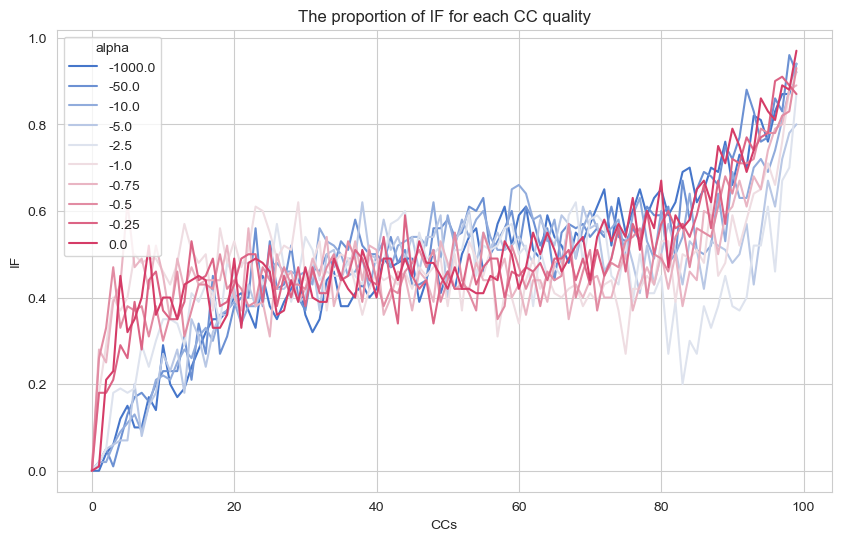

C:\Users\123\AppData\Local\Temp\ipykernel_22744\3731370793.py:7: UserWarning: The palette list has more values (10) than needed (9), which may not be intended.
  sns.lineplot(data=df, x=b, y=c, hue=a, palette=custom_palette)


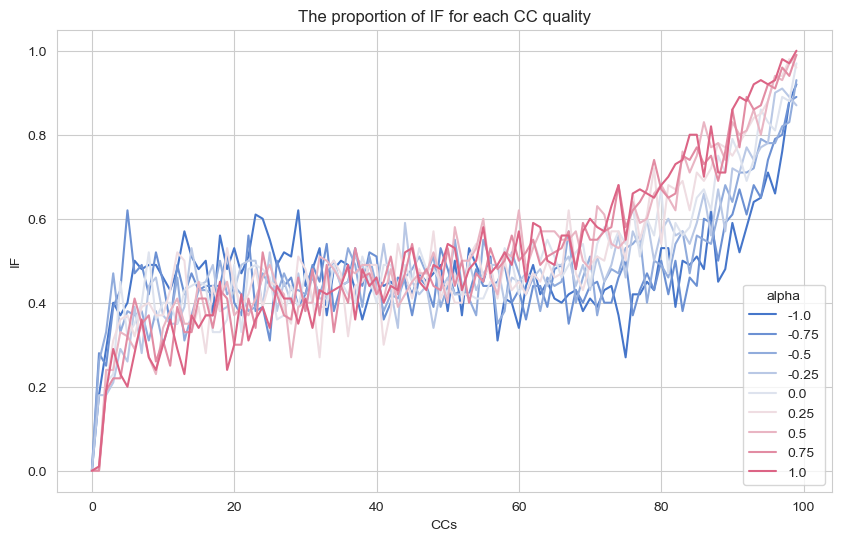

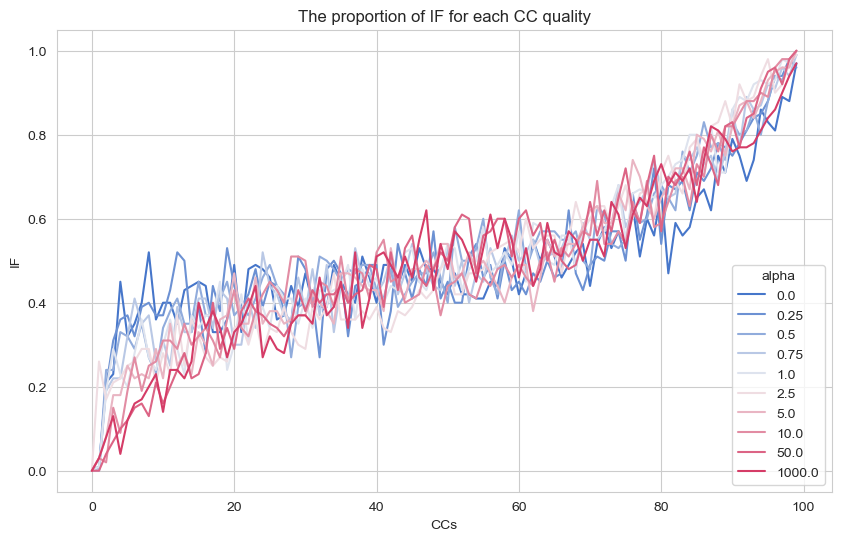

In [31]:
# plot the alpha separately
alpha_anti = [-1000, -50, -10, -5, -2.5, -1, -0.75, -0.5, -0.25, 0]
alpha_UR = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
alpha_PA = [0, 0.25, 0.5, 0.75, 1, 2.5, 5, 10, 50, 1000]
for i in [alpha_anti, alpha_UR, alpha_PA]:
    filtered_fair = cc_fair_df[cc_fair_df['alpha'].isin(i)]
    plot(filtered_fair, 'alpha', 'id', 'IF')

Describe the correlation between frequency, quality and # of followers

In [32]:
# choose a sumulation result for the
cc_one = cc_all[cc_all['iteration'] == 5]
alpha_list = [-1000, -2.5, -1, 0, 1, 2.5, 1000]
# for i in alpha_list:
#     df_i = cc_one[cc_one['alpha'] == i]


Index(['id', 'subs', 'view', 'frequency', 'iteration', 'alpha', 'rank', 'IF'], dtype='object')

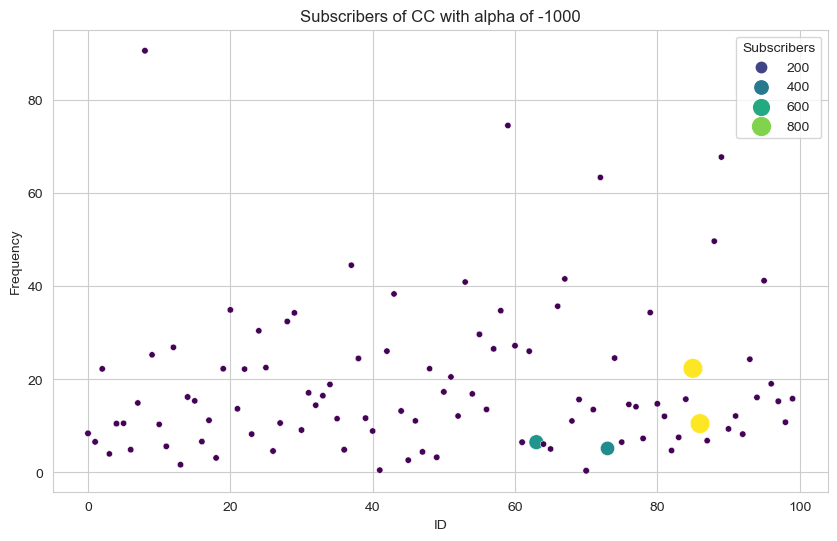

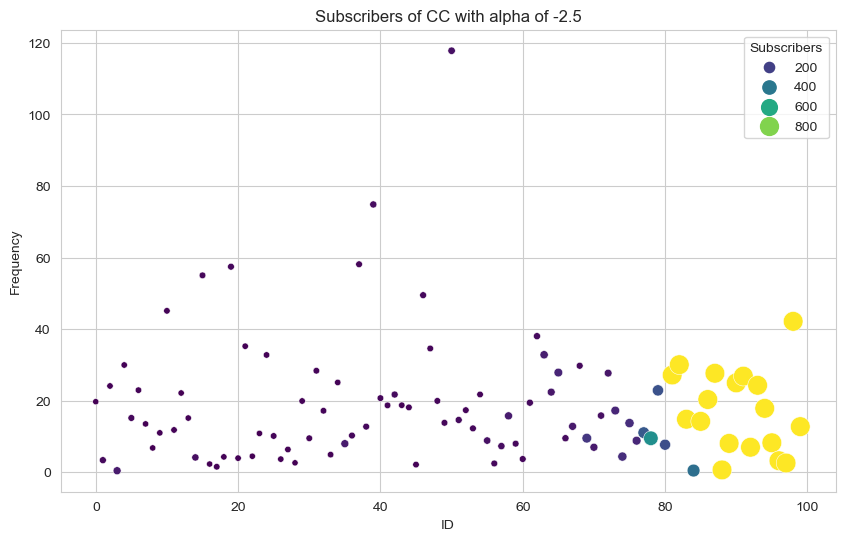

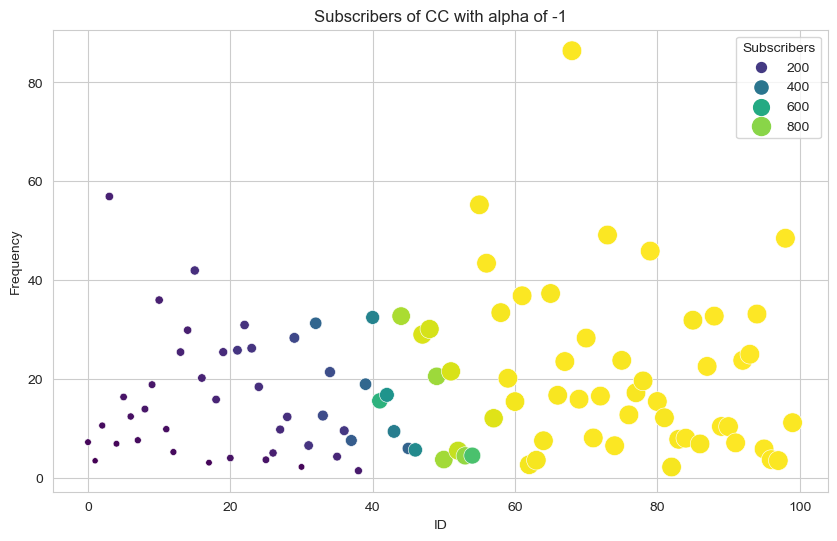

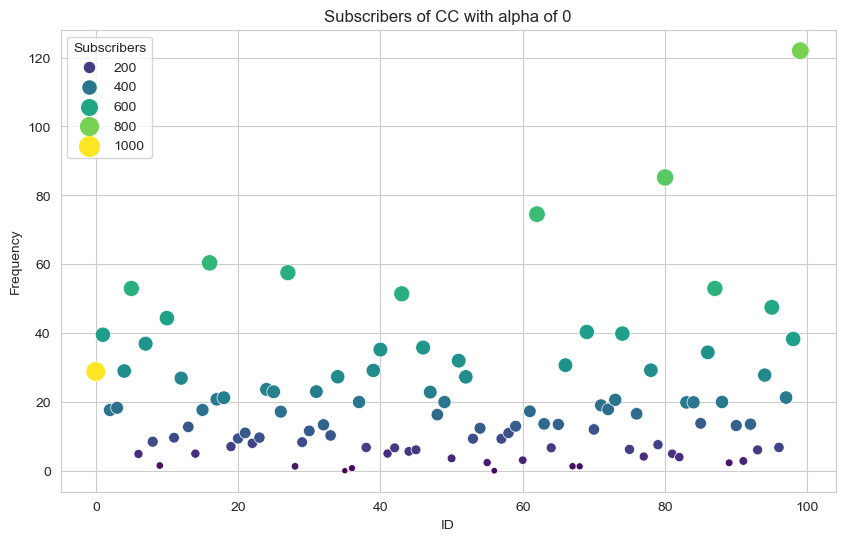

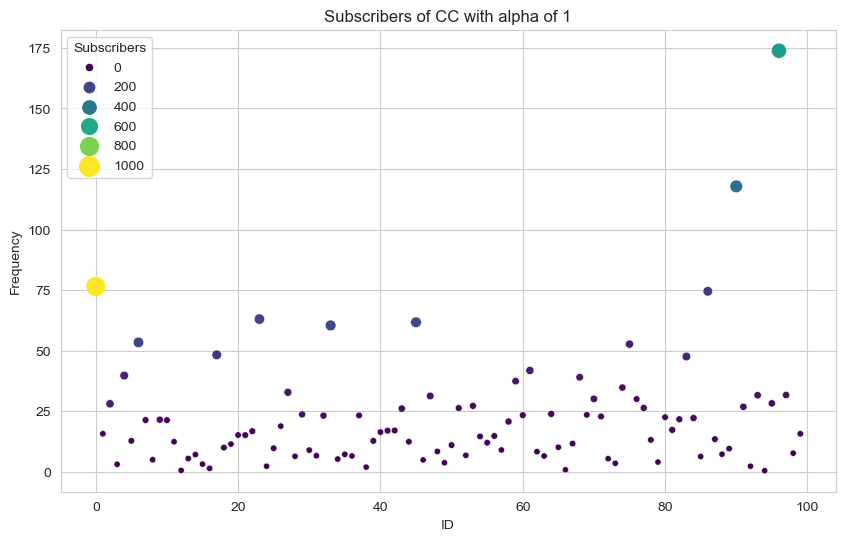

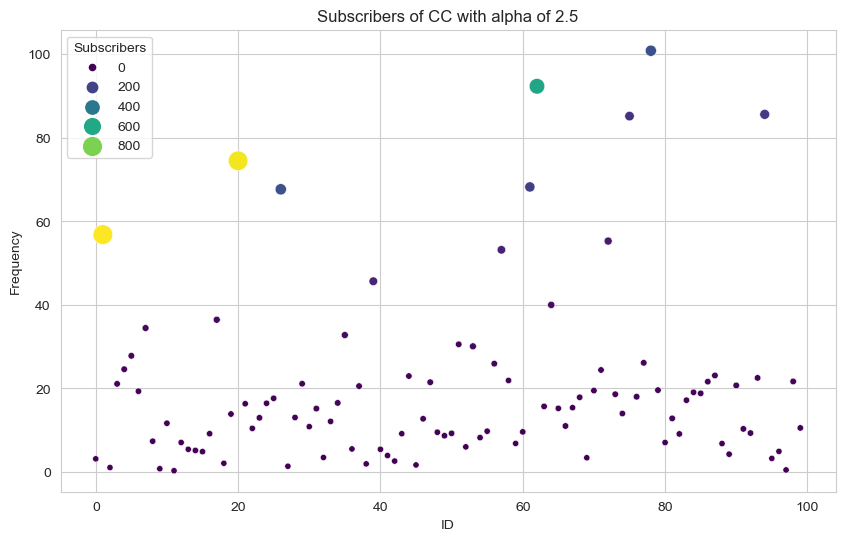

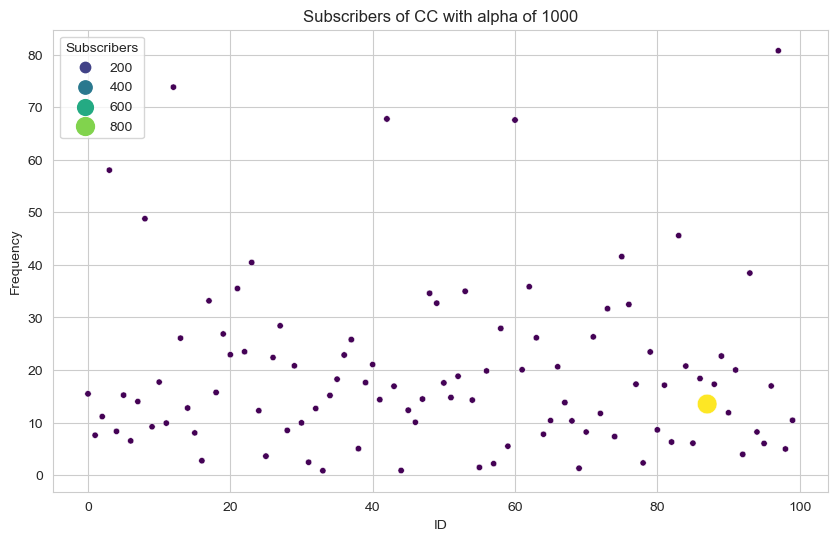

In [36]:
# Todo: combine different values

#
for alpha in alpha_list:
    df_i = cc_one[cc_one['alpha'] == alpha]
    plt.figure(figsize=(10, 6))  # 设置图像大小
    ax = plt.gca()
    sns.scatterplot(data=df_i, x='id', y='frequency', size='subs', hue='subs', sizes=(20, 200), palette='viridis', ax=ax)

    plt.xlabel('ID')  # 设置横坐标标签
    plt.ylabel('Frequency')  # 设置纵坐标标签
    plt.title(f'Subscribers of CC with alpha of {alpha}')  # 设置标题
    plt.legend(title='Subscribers')  # 设置图例标题
    plt.show()

Plot the converged proportion at different steps

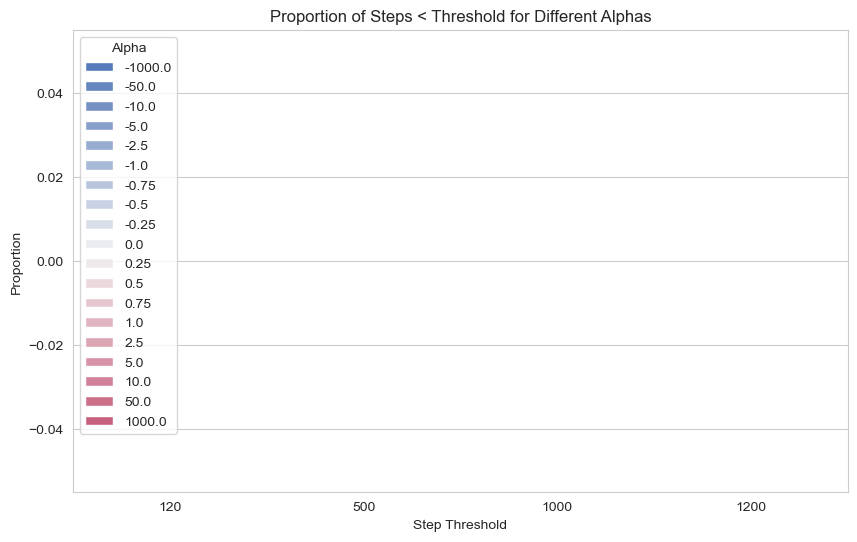

In [38]:
step_list = [120, 500, 1000, 1200]
a = simu_stop_proportion(user_all, step_list)
# colors = sns.color_palette("husl", n_colors=len(a))
colors = sns.diverging_palette(255, 1, n=20)
plt.figure(figsize=(10, 6))

# 使用 Seaborn 绘制柱状图
sns.barplot(x='threshold', y='iteration', data=a, hue='alpha', palette=colors)

plt.xlabel('Step Threshold')
plt.ylabel('Proportion')
plt.title('Proportion of Steps < Threshold for Different Alphas')
plt.legend(loc='upper left', title='Alpha')

plt.show()

Analysis from user side,

C:\Users\123\AppData\Local\Temp\ipykernel_9940\1211046040.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='steps', y='proportion', data=b, hue='alpha', palette=colors)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


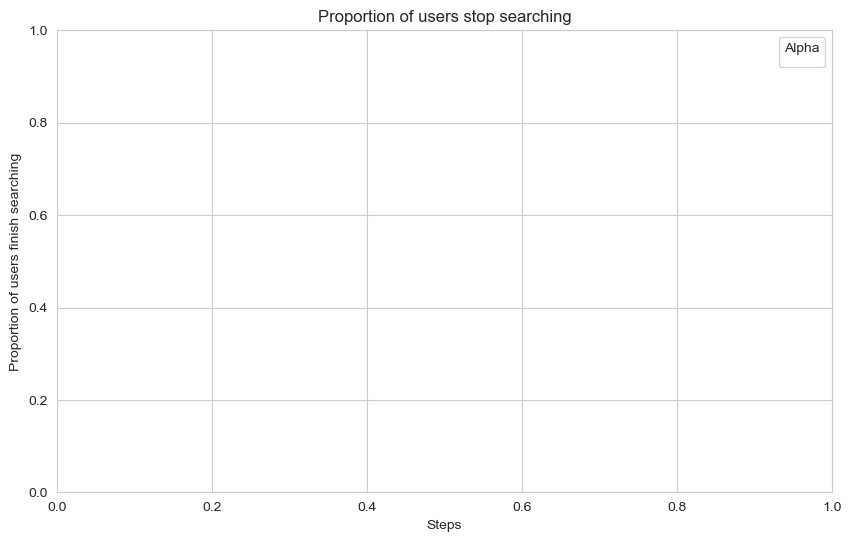

In [17]:
# since some iterations (PA) need more steps for converged, I slice the step value at 25
user_proportion = user_searching_proportion(user_all)
b = user_proportion[user_proportion['steps']<25]

colors = sns.diverging_palette(255, 1, n=15)
plt.figure(figsize=(10, 6))

# 使用 Seaborn 绘制柱状图
sns.lineplot(x='steps', y='proportion', data=b, hue='alpha', palette=colors)

plt.xlabel('Steps')
plt.ylabel('Proportion of users finish searching')
plt.title('Proportion of users stop searching')
plt.legend(title='Alpha')

plt.show()

In [ ]:
user_all['satisfaction'] = [100 - min(followed) for followed in user_all['followed']]

In [ ]:
user_all.groupby('alpha')['satisfaction'].mean()